# Session Based Recommendation with RNN Movielens Dataset🎬

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

__Session-Based Recommendation__<br>
    세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천
    세션이란? 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터

## 루브릭
|평가문항|상세기준|
|:---|:---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다|

***

## 1. Data Preprocess

### 1.1 Data Load

__Movielens 1M Dataset__

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [44]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 1.2 Session Id
- 해당 데이터 셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다.
- 시용자의 고유키인 UserId는 시간을 고려하지 않으므로 고유한 시간과 UserId 정보를 가진 SessionId를 생성합니다.
- 날짜 및 시간을 파악하기 위해서 Time 컬럼을 Time unit으로 변경한 컬럼 Timestamp를 추가합니다.

In [94]:
session = data.groupby(['UserId', 'TimeStamp']).count().reset_index()
# session.reset_index(inplace=True)
session

,UserId,TimeStamp,ItemId,Rating,Time
0,1,2000-12-31 22:00:19,1,1,1
1,1,2000-12-31 22:00:55,3,3,3
2,1,2000-12-31 22:01:43,1,1,1
3,1,2000-12-31 22:02:52,1,1,1
4,1,2000-12-31 22:04:35,1,1,1
...,...,...,...,...,...
471158,6040,2001-08-10 14:39:58,1,1,1
471159,6040,2001-08-10 14:40:29,1,1,1
471160,6040,2001-08-10 14:41:04,2,2,2
471161,6040,2001-08-10 14:41:26,1,1,1


In [15]:
# 시간 확인하기 위해 Time unit으로 데이터 변환하여 컬럼을 추가합니다.
def int_to_time(num):
    return pd.Timestamp(num, unit='s')
data['TimeStamp'] = data['Time'].map(lambda x: int_to_time(x))

,UserId,ItemId,Rating,Time,TimeStamp
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


추천시스템을 구축할 때 주요하게 사용되는 변수인 세션 수와 아이템 수를 확인합니다.

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 1.2 Session Length
각 유저가 약 몇 개의 영화를 시청했는지 확인합니다.

In [6]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
print(session_length.min()) # session_length 최소값
print(session_length.median())# session_length 중위값
print(session_length.mean())# session_length 평균
print(session_length.quantile(0.999))# session_length 0.999
print(session_length.max())# session_lengt 최대값

20
96.0
165.5975165562914
1343.181000000005
2314


중위값과 평균의 차이가 크기때문에 큰 값들로 인한 영향이 있는 것을 알 수 있습니다. 
최대값은 중위값의 20배 이상인 수치를 보입니다. heavy user이거나 이상치일 것 같습니다.

In [16]:
long_session = session_length[session_length>2000].index[0]

data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,TimeStamp
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


같은 시간에 여러 영화를 동시에 볼 수 는 없으니 이상치로 파악 됩니다.
다른 유저들도 이런 경우가 있는 지 살펴보겠습니다.

In [59]:
same_time = data.groupby(['UserId', 'TimeStamp']).count()
same_time['ItemId']

UserId  TimeStamp          
1       2000-12-31 22:00:19    1
        2000-12-31 22:00:55    3
        2000-12-31 22:01:43    1
        2000-12-31 22:02:52    1
        2000-12-31 22:04:35    1
                              ..
6040    2001-08-10 14:39:58    1
        2001-08-10 14:40:29    1
        2001-08-10 14:41:04    2
        2001-08-10 14:41:26    1
        2001-08-20 13:44:15    1
Name: ItemId, Length: 471163, dtype: int64

In [58]:
same_time['ItemId'].describe()

count    471163.000000
mean          2.122851
std           1.546899
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: ItemId, dtype: float64

<AxesSubplot:xlabel='UserId,TimeStamp'>

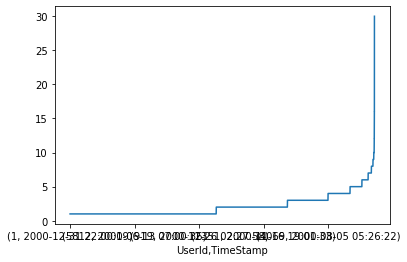

In [62]:
same_time['ItemId'].sort_values().plot()

In [88]:
same_time[same_time>10]['ItemId'].sum() / same_time['ItemId'].sum()

0.0065656277837931876

같은 UserId로 동시간대에 2개 이상의 영화를 본 사용자가 많이 존재합니다. 넷플릭스 같이 여러 명이 동시에 볼 수 있는 서비스 일수도 있겠네요.
하지만 동시간대에 30명의 시청기록은 이상한 데이터라고 판단됩니다.
동시간대의 6개 이상의 영화를 보는 경우는 전체 데이터에서 약 14%를 차지합니다. 데이터 클렌징 단계에서 여기에 속한 데이터는 제거하고 사용하겠습니다.

세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화합니다.

In [86]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

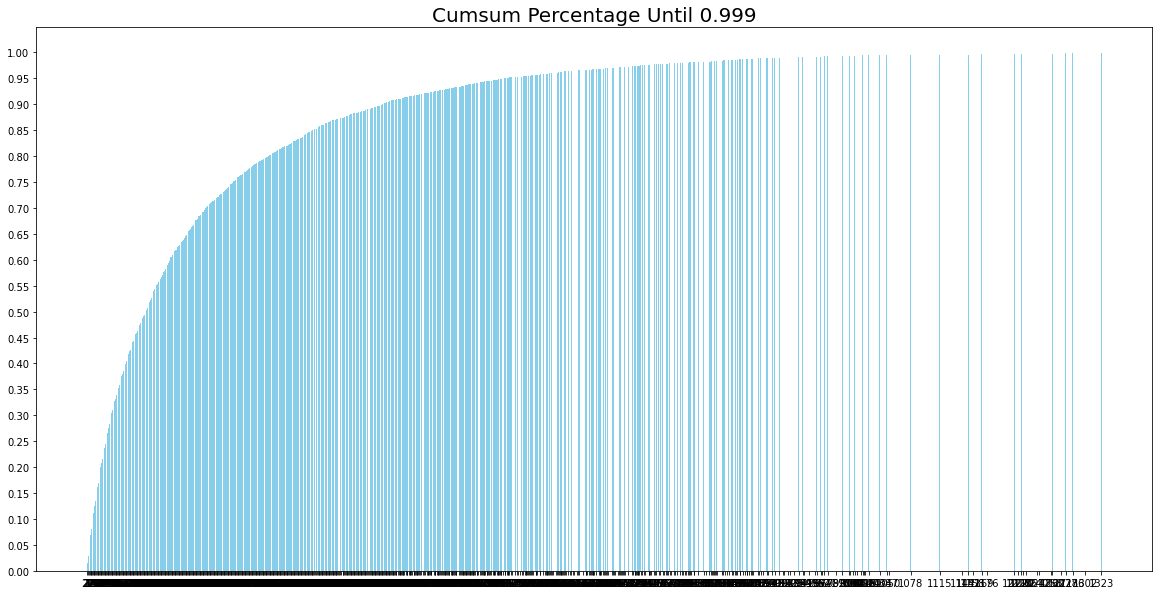

In [87]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='skyblue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1.3 Session Time

### 1.4 Data Cleaning

### 1.5 Train/Valid/Test Split

***

## 프로젝트 정리

### 주요 개념 정리

1. Session Based Recommendation
2. GRU4Rec
2. 평가기준

1️⃣__배운 것__<br>
2️⃣__시도해본 것__<br>
3️⃣__더 해볼것__<br>

### 참고자료